<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Parallelization In Numba

* Setting the parallel flag in Numba
`@njit(parallel=True)` will attempts to automatically parallelize the function
* This feature is currently supported on CPUs only (we'll talk about Numba's GPU capabilities later)
* The idea behind automatic parallelization is that some operations are trivial to parallelize

> Example: it's easy to parallelize an operation like adding a constant to an array

* Numba attempts to identify these easily parallelized operations in a function and fuse adjacent ones together, to form one or more kernels that are automatically run in parallel



## Supported Operations
The Numba docs outline which operations support automatic parallelization. These primary include operations on NumPy arrays. These include:

1. Common arithmetic functions between NumPy arrays and between arrays and scalars:
    * Unary operators: `+`, `-`, `~`
    * Binary operators: `+`, `-` `*`, `/`, `/?`, `%`, `|`, `>>`, `^`, `<<`, `&`, `**`, `//`
    * Comparison operators: `==`, `!=`, `<`, `<=`>, `>`, `>=`
    * NumPy ufuncs that are supported in nopython mode
    * Numba functions with the `@vectorize` decorator

2. NumPy reduction functions:
    * `sum`, `prod`, `min`, `max`, `argmin`, `argmax`, `mean`, `var`, `std`
3. NumPy array creation functions:
    * `zeros`, `ones`, `arange`, `linspace`, `rand`, `randn`, among others
4. The NumPy `dot` function between a matrix and vector or two vectors
5. Multi-dimensional arrays are also supported for the above operations when operands have matching dimension and size
7. Some basic use of indexing and slicing notation

### Example: Image Preprocessing

* Let's look at an example to see how this works in practice
* Below we define a function called `preprocess_image_serial` that clips an image of a specified range, normalizes it, and replaces 0 values with `NaN`

In [ ]:
import numpy as np
import time
import numba
from numba import njit, get_num_threads

# A serial image processing function
@njit
def preprocess_image_serial(img, low=0.0, high=1.0, bg_value=np.nan):
    out = img.copy()
    # Clip via min/max (Numba-friendly)
    out = np.maximum(out, low)
    out = np.minimum(out, high)

    # Normalize to [0, 1]
    rng = high - low
    if rng != 0.0:
        out = (out - low) / rng

    # Replace zeros with bg_value using np.where
    out = np.where(out == 0.0, bg_value, out)
    return out

* Next, we define a function with the exact same code but set the parallel flag
* The number of threads used in computations can be set using `set_num_threads`
* Note that unlike Python, where threading is restricted to a single core due the the GIL (at least until Python 3.14 is released), Numba doesn't have this restriction
* Hence, each thead can execute on a different logical core

In [ ]:
# The parallel version
@njit(parallel=True)
def preprocess_image_parallel(img, low=0.0, high=1.0, bg_value=np.nan):
    out = img.copy()
    out = np.maximum(out, low)
    out = np.minimum(out, high)
    rng = high - low
    if rng != 0.0:
        out = (out - low) / rng
    out = np.where(out == 0.0, bg_value, out)
    return out

####  Performance v. Grid Size
* To see if Numba successfully sped up this funciton let's benchmark both the serial and parallel versions across several grid sizes
* We'll use `set_num_threads` to determine the number of logical cores used

500x500: serial=0.0008s, parallel=0.0015s, speedup=0.52x
1000x1000: serial=0.0039s, parallel=0.0055s, speedup=0.70x
2000x2000: serial=0.0249s, parallel=0.0283s, speedup=0.88x
3000x3000: serial=0.1905s, parallel=0.1152s, speedup=1.65x
4000x4000: serial=0.3354s, parallel=0.1950s, speedup=1.72x
5000x5000: serial=0.5140s, parallel=0.3005s, speedup=1.71x


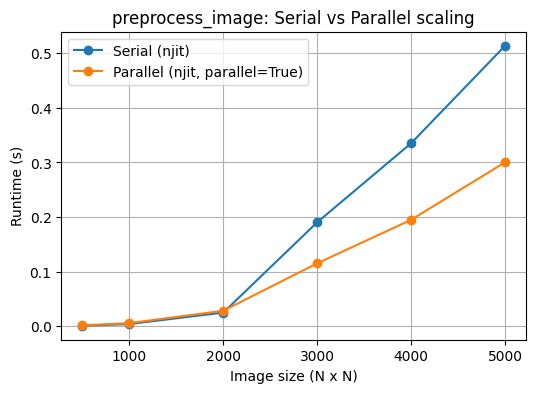

In [ ]:
import matplotlib.pyplot as plt
from numba import set_num_threads

# Set the number of threads for parallelism
set_num_threads(4)

def time_func(fn, arr, repeats=3):
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = fn(arr)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.mean(times)

# Iterate through several grid sizes
sizes = [500, 1000, 2000, 3000, 4000, 5000]  # square images
serial_times = []
parallel_times = []

# Warm-up JIT compile
img0 = np.random.rand(200,200).astype(np.float32)
preprocess_image_serial(img0)
preprocess_image_parallel(img0)

# Benchmark for different grid sizes
for n in sizes:
    img = np.random.rand(n, n).astype(np.float32)
    t_ser = time_func(preprocess_image_serial, img)
    t_par = time_func(preprocess_image_parallel, img)
    serial_times.append(t_ser)
    parallel_times.append(t_par)
    print(f"{n}x{n}: serial={t_ser:.4f}s, parallel={t_par:.4f}s, speedup={t_ser/t_par:.2f}x")

# Plot
plt.figure(figsize=(6,4))
plt.plot(sizes, serial_times, "o-", label="Serial (njit)")
plt.plot(sizes, parallel_times, "o-", label="Parallel (njit, parallel=True)")
plt.xlabel("Image size (N x N)")
plt.ylabel("Runtime (s)")
plt.title("preprocess_image: Serial vs Parallel scaling")
plt.legend()
plt.grid(True)
plt.show()

* Okay, so the serial version is faster until we get to larger image sizes of about $2000\times 2000$
* Essentially, the overhead of using multiple threads doesn't justify its cost
* For small arrays, spinning up worker threads, dividing work into chunks, and synchronizing threads comes with a cost
* This cost outweighs any benefit from parallelism
* For large arrays, the parallel version starts to pull ahead
* For these large arrays, the cost of launching worker threads is small relative to the amount of computation that needs to be done

#### Performance v. Threads
* Let's also consider how performance scales with the number of threads used for large images


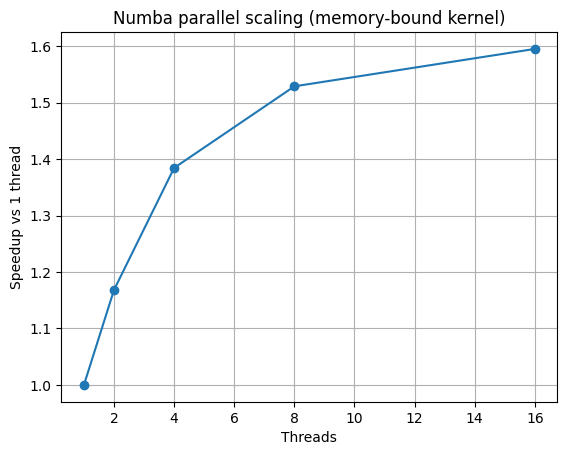

In [ ]:
# warm-up JIT
img = np.random.rand(5000, 5000).astype(np.float32)
_ = preprocess_image_parallel(img)

def time_run(nthreads, repeats=3):
    set_num_threads(nthreads)
    best = 1e9
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = preprocess_image_parallel(img)
        t1 = time.perf_counter()
        best = min(best, t1 - t0)
    return best

thread_counts = [1, 2, 4, 8, 16]
times = [time_run(n) for n in thread_counts]

plt.plot(thread_counts, [times[0]/t for t in times], "o-")
plt.xlabel("Threads")
plt.ylabel("Speedup vs 1 thread")
plt.title("Numba parallel scaling (memory-bound kernel)")
plt.grid(True)
plt.show()

* We eventually start hitting a platea at about 8 threads on $5000 \times 5000$ images where we see a nominal speefup as more cores are added

**Takeaways**
1. Parallelization only requires the use of the `parallel` flag in the dectorator
2. This example does see a performance improvement from parallelization, however it is not apparent until we get to large image sizes
3. This demonstrates the importance of profiling and benchmarking. The utility of parallelism depends on the problem size and the overhead of communication / synchronization
4. Adding more cores can lead to better performance, but recall in Amdahl's law that there are dimishing returns even in the best case

## Explicit Parallel Loops

* In addition to supporting automatic parallelization of certain operations, Numba supports explicit parallel loops

> The user is required to make sure that the loop does not have cross iteration dependencies except for supported reductions!

* Parallel loops use Numbas `prange` function which works similarly to range
* For example, this code will compute the sums of rows in an array in parallel
* In this case row sums are independent, so this works fine

In [ ]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def row_sums(A):
    nrows = A.shape[0]
    out = np.empty(nrows, dtype=A.dtype)
    for i in prange(nrows):       # iterations are independent
        s = 0.0
        for j in range(A.shape[1]):
            s += A[i, j]
        out[i] = s
    return out

# Demo
A = np.random.rand(4000, 4000)
print(row_sums(A)[:5])


[1987.85678598 1987.62763577 2023.56483973 1997.44347802 2025.39950008]


* This code shows an example of how things go wrong
* Here, there is a cross iteration dependency which results in odd behavior due to race conditions

In [ ]:
@njit(parallel=True)
def prefix_sum(a):
    n = len(a)
    out = np.empty(n, dtype=a.dtype)
    out[0] = a[0]
    for i in prange(1, n):      # BAD: dependency on out[i-1]
        out[i] = out[i-1] + a[i]
    return out


a = np.ones(1000)
out = prefix_sum(a)
expected = np.cumsum(out)
print(np.allclose(out, expected))
print(out)

False
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.   1.   2.   3.   4.   5.   6.


## Example: Cosine Similarity Using Prange


* Here we'll consider computing the the cosine between all rows of a matrix $X$ with a vector $v$
* Cosine similarity is sometimes use in AI applications (for example in the cosine distance loss function)
* The cosine similarity between two vectors $x$ and $y$ is computed as
$$ \text{cosine\_sim} (x, y) = \frac{x \cdot y}{||x|| \; ||y||}  $$
* `prange` is applicable here because the cosine similarity between all rows of in $x$ and $v$ are independent of each other

rows=  2000  serial=0.0021s  parallel=0.0005s  speedup=3.93x
rows=  5000  serial=0.0052s  parallel=0.0013s  speedup=3.96x
rows= 10000  serial=0.0105s  parallel=0.0026s  speedup=4.08x
rows= 20000  serial=0.0211s  parallel=0.0052s  speedup=4.08x
rows= 40000  serial=0.0421s  parallel=0.0081s  speedup=5.19x
Outputs close: True


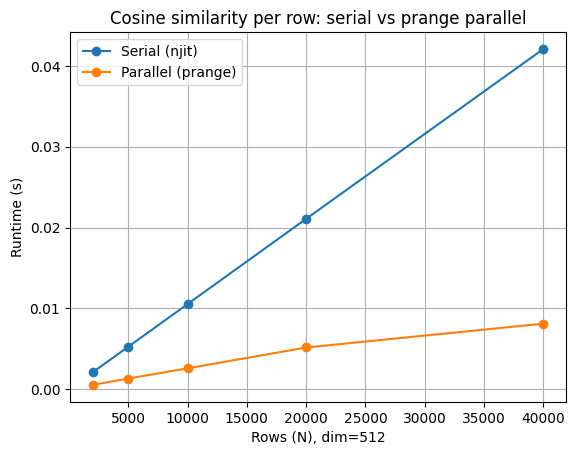

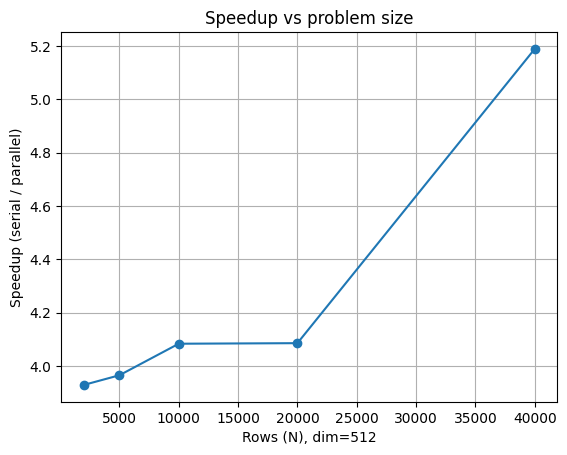

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import njit, prange, set_num_threads

# We'll try 8 threads
set_num_threads(8)

# Serial cosine similarity
@njit(parallel=False)
def cosine_row_serial(X, v):
    n, d = X.shape
    out = np.empty(n, dtype=X.dtype)
    for i in range(n):
        # dot
        s = 0.0
        for j in range(d):
            s += X[i, j] * v[j]
        # norms
        nx = 0.0
        for j in range(d):
            nx += X[i, j] * X[i, j]
        nv = 0.0
        for j in range(d):
            nv += v[j] * v[j]
        denom = (nx ** 0.5) * (nv ** 0.5)
        out[i] = s / denom if denom != 0.0 else 0.0
    return out

# Parallel verison using prange
@njit(parallel=True)
def cosine_row_prange(X, v):
    n, d = X.shape
    out = np.empty(n, dtype=X.dtype)
    for i in prange(n):                    # parallel over rows
        s = 0.0
        for j in range(d):
            s += X[i, j] * v[j]
        nx = 0.0
        for j in range(d):
            nx += X[i, j] * X[i, j]
        nv = 0.0
        for j in range(d):
            nv += v[j] * v[j]
        denom = (nx ** 0.5) * (nv ** 0.5)
        out[i] = s / denom if denom != 0.0 else 0.0
    return out

# Create an array x and a vector v

def make_data(n_rows, dim=512, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n_rows, dim), dtype=np.float32)
    v = rng.standard_normal(dim, dtype=np.float32)
    return X, v

def best_time(fn, *args, warmup=True, repeats=5):
    if warmup:
        fn(*args)  # trigger JIT + warm cache
    best = float("inf")
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = fn(*args)
        t1 = time.perf_counter()
        best = min(best, t1 - t0)
    return best

# Benchmakr different problem sizes

sizes = [2000, 5000, 10000, 20000, 40000]  # number of rows
dim = 512

# Warm-up compile with a small instance so timing excludes JIT cost
X0, v0 = make_data(512, dim)
_ = cosine_row_serial(X0, v0)
_ = cosine_row_prange(X0, v0)

serial_times = []
parallel_times = []
speedups = []

for n in sizes:
    X, v = make_data(n, dim, seed=42)
    t_ser = best_time(cosine_row_serial, X, v)
    t_par = best_time(cosine_row_prange, X, v)
    serial_times.append(t_ser)
    parallel_times.append(t_par)
    sp = t_ser / t_par
    speedups.append(sp)
    print(f"rows={n:6d}  serial={t_ser:.4f}s  parallel={t_par:.4f}s  speedup={sp:.2f}x")

# Are the results the same

X_chk, v_chk = make_data(4096, dim, seed=123)
y_ser = cosine_row_serial(X_chk, v_chk)
y_par = cosine_row_prange(X_chk, v_chk)
print("Outputs close:", np.allclose(y_ser, y_par, rtol=1e-5, atol=1e-6))

# Plots

plt.figure()
plt.plot(sizes, serial_times, "o-", label="Serial (njit)")
plt.plot(sizes, parallel_times, "o-", label="Parallel (prange)")
plt.xlabel("Rows (N), dim=512")
plt.ylabel("Runtime (s)")
plt.title("Cosine similarity per row: serial vs prange parallel")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(sizes, speedups, "o-")
plt.xlabel("Rows (N), dim=512")
plt.ylabel("Speedup (serial / parallel)")
plt.title("Speedup vs problem size")
plt.grid(True)
plt.show()


* Another reasonable question to ask here is how the performance compares when using explicit parallel loops versus using automatic parallelization
* Well, let's give auto parallelization a try for this example

<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
@njit(parallel=True)
def cosine_row_auto(X, v):
    n, d = X.shape
    out = np.empty(n, dtype=X.dtype)
    for i in range(n):
        # dot
        s = 0.0
        for j in range(d):
            s += X[i, j] * v[j]
        # norms
        nx = 0.0
        for j in range(d):
            nx += X[i, j] * X[i, j]
        nv = 0.0
        for j in range(d):
            nv += v[j] * v[j]
        denom = (nx ** 0.5) * (nv ** 0.5)
        out[i] = s / denom if denom != 0.0 else 0.0
    return out

cosine_row_auto(X_chk, v_chk)


/home/vscode/.local/lib/python3.12/site-packages/numba/core/typed_passes.py:338: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../tmp/ipykernel_1081/854273388.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


array([ 0.06020574, -0.03101641,  0.05254392, ...,  0.02410629,
        0.02812225, -0.05666285], shape=(4096,), dtype=float32)

* Oh no! It turns out that Numba can't figure out a way to parallelize this one
* Numba is not good at automatically parallelizing arbitrary Python loops like in this example
* It is built to  parallelize array expressions
* Hence, to use the auto parallelization, we'd have to rewrite it as such

In [ ]:
from numba import njit
import numpy as np

@njit(parallel=True)
def cosine_row_auto_vec(X, v):
    s  = (X * v).sum(axis=1)           # rowwise dot
    nx = np.sqrt((X * X).sum(axis=1))  # rowwise norm
    nv = np.sqrt((v * v).sum())        # scalar norm
    denom = nx * nv
    out = s / denom
    m = denom == 0.0                   # safe divide
    if np.any(m):
        out[m] = 0.0
    return out

N=  2000  auto-vec=0.0058s   prange=0.0003s   ratio(prange/auto)=0.05
N=  5000  auto-vec=0.0140s   prange=0.0007s   ratio(prange/auto)=0.05
N= 10000  auto-vec=0.0612s   prange=0.0027s   ratio(prange/auto)=0.04
N= 20000  auto-vec=0.1472s   prange=0.0054s   ratio(prange/auto)=0.04
N= 40000  auto-vec=0.3179s   prange=0.0097s   ratio(prange/auto)=0.03


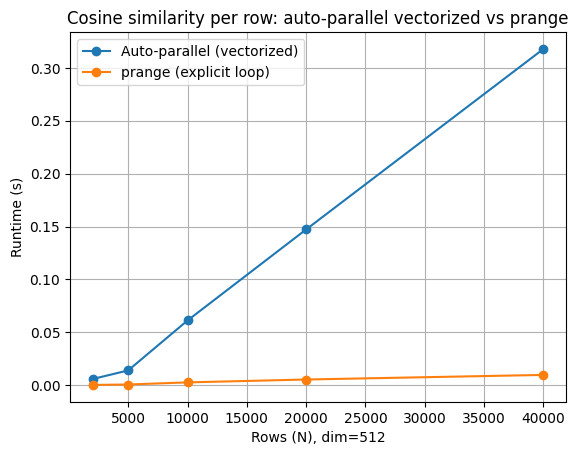

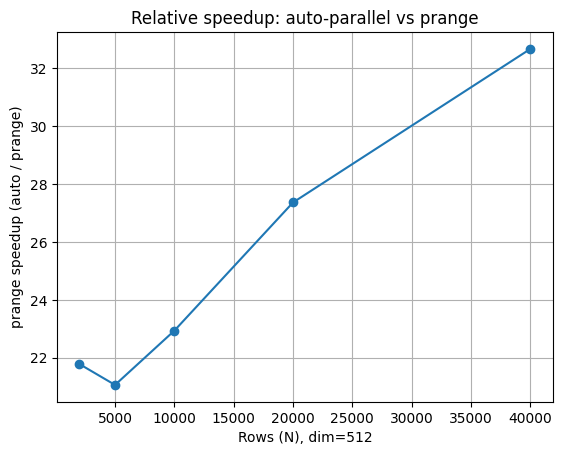

In [ ]:
set_num_threads(8)

rng = np.random.default_rng(0)
D = 512
sizes = [2000, 5000, 10000, 20000, 40000]  # rows to sweep

# Warm-up compile
X0 = rng.standard_normal((1024, D), dtype=np.float32)
v0 = rng.standard_normal(D, dtype=np.float32)
_ = cosine_row_auto_vec(X0, v0)
_ = cosine_row_prange(X0, v0)


# Benchmark loop
auto_times = []
prange_times = []
for N in sizes:
    X = rng.standard_normal((N, D), dtype=np.float32)
    v = rng.standard_normal(D, dtype=np.float32)
    # correctness
    y_auto = cosine_row_auto_vec(X, v)
    y_pr   = cosine_row_prange(X, v)
    ok = np.allclose(y_auto, y_pr, rtol=1e-5, atol=1e-6)
    if not ok:
        print("WARNING: outputs differ at N=", N)
    # timings
    t_auto = best_time(cosine_row_auto_vec, X, v)
    t_pr   = best_time(cosine_row_prange, X, v)
    auto_times.append(t_auto)
    prange_times.append(t_pr)
    print(f"N={N:6d}  auto-vec={t_auto:.4f}s   prange={t_pr:.4f}s   ratio(prange/auto)={t_pr/t_auto:.2f}")

# Plot
plt.figure()
plt.plot(sizes, auto_times, "o-", label="Auto-parallel (vectorized)")
plt.plot(sizes, prange_times, "o-", label="prange (explicit loop)")
plt.xlabel("Rows (N), dim=512")
plt.ylabel("Runtime (s)")
plt.title("Cosine similarity per row: auto-parallel vectorized vs prange")
plt.legend()
plt.grid(True)
plt.show()


auto_arr = np.array(auto_times)
prange_arr = np.array(prange_times)

plt.figure()
plt.plot(sizes, auto_arr / prange_arr, "o-")
plt.xlabel("Rows (N), dim=512")
plt.ylabel("prange speedup (auto / prange)")
plt.title("Relative speedup: auto-parallel vs prange")
plt.grid(True)
plt.show()


* Okay, so now that we've modified cosine similarity so that is can be automatically parallelized, we can compare the two
* `prange` seems to have a significant performance advantage in this case
* What are some possible reasons for this?

    1. The vectorized versions performs multiple loops over the data
    2. More use of temporary variables for the auto parallel version
    3. ?

* One of the disadvantages of auto parallelization is a lack of transparency
* You don't really know without delving into the diagnostics and Numba code how operations are being parallelized
* In contrast, `prange` offers slightly more control
* Compare this with something like `mpi4py` which adds another level of granular control